In [29]:
import torch
from torch import nn
import collections
import matplotlib.pyplot as plt
from IPython import display

from tabulate import tabulate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder, OneHotEncoder\
    , FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

from common.optim.meta import MetaData
from common.optim.optimise_v5 import NetLineStepProcessorMSE
from common.ffn_minst_relu import RegressionReLU, MNISTReLU

import logging

In [30]:
logging.basicConfig(filename="logs/california_housing_regression.log",
                level=logging.INFO,
                format="%(levelname)s: %(asctime)s %(message)s",
                datefmt="%m/%d/%Y %I:%M:%S")

#### Constants

In [31]:
OUTPUT_DIM=1
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

slope_plus, slope_minus=1.0, 0.0

EXPERIMENTS = 10
#EPOCHS_PER_EXPERIMENT = 30
#DATASET_PATH = "./datasets"

#### California housing dataset

In [32]:
rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6

class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
        population_per_household=X[:,population_ix]/X[:,household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

num_attribs=["longitude", "latitude", "housing_median_age", "total_rooms", \
    "total_bedrooms", "population", "households", "median_income"]
cat_attribs=["ocean_proximity"]

num_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("feature_adder",FeatureAdder()),
    ("std_scaler",StandardScaler()),
])

full_pipeline=ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [33]:
housing = pd.read_csv("datasets_regression/housing.csv")
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"]=housing["income_cat"].apply(lambda x: 5 if x>5 else x)


#### Utils

In [34]:
def print_loss(history_params):
    display.clear_output()
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    axes.set_title('Loss (RMSE)')
    axes.plot(history_params['test_loss'], color='g',alpha=.5, label='Net-line two-steps')
    axes.grid()
    axes.legend()
    axes.set_xlabel("Gradient descent step")
    axes.set_ylabel("Loss value")
    plt.show()

#### Series of experiments

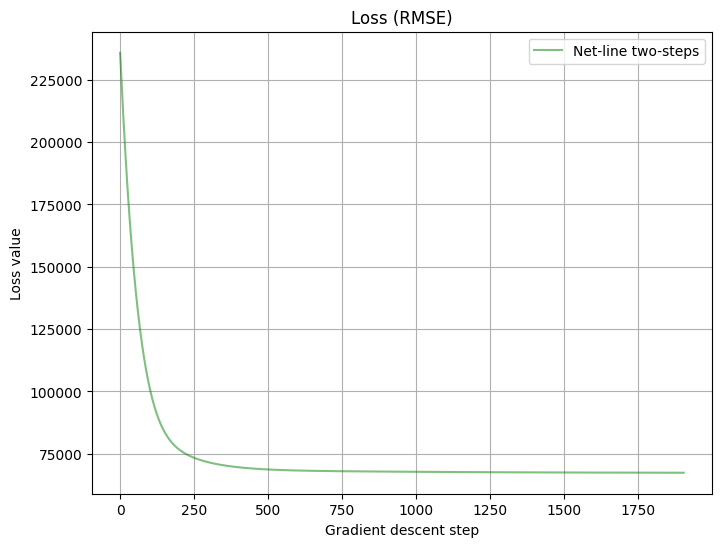

RMSE values: Linear =68835.52477669854, NetLine=67379.49151668757, RandomForest=50845.355388317716


In [35]:
def rmse_netline_validation(net_regression, X_test_prepared_tn, Y_test):
    with torch.no_grad():
        net_predictions= net_regression.forward(X_test_prepared_tn)
        return np.sqrt(mean_squared_error(Y_test, torch.squeeze(net_predictions).cpu().numpy()))

RMSE_VALUES = collections.defaultdict(list)

for _ in range(EXPERIMENTS):
    split= StratifiedShuffleSplit(n_splits=1,test_size=0.2) #,random_state=42
    for train_idx,test_idx in split.split(housing,housing["income_cat"]):
        strat_train_set = housing.loc[train_idx]
        strat_test_set = housing.loc[test_idx]

    temp = (strat_train_set, strat_test_set)
    for ii in temp:
        ii.drop(["income_cat"],axis=1,inplace=True)

    Y_train=strat_train_set["median_house_value"].copy()
    X_train=strat_train_set.drop("median_house_value",axis=1)
    X_train_prepared = full_pipeline.fit_transform(X_train)

    Y_test= strat_test_set["median_house_value"].copy()
    X_test= strat_test_set.drop("median_house_value",axis=1)
    X_test_prepared = full_pipeline.transform(X_test)

    #Train with linear regression, MSE value on test set is estimited
    lin_reg=LinearRegression()
    lin_reg.fit(X_train_prepared,Y_train)
    lin_predictions= lin_reg.predict(X_test_prepared)
    lin_rmse= np.sqrt(mean_squared_error(Y_test,lin_predictions))
    RMSE_VALUES["Linear"].append(lin_rmse)

    #Train with random forest regressor, MSE value on test set is estimited
    forest_reg = RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10)
    forest_reg.fit(X_train_prepared,Y_train)
    forest_predictions= forest_reg.predict(X_test_prepared)
    forest_rmse= np.sqrt(mean_squared_error(Y_test, forest_predictions))
    RMSE_VALUES["Forest"].append(forest_rmse)

    #Train with two-step algorithm
    X_train_prepared_tn = torch.from_numpy(X_train_prepared).float().to(DEVICE)
    Y_train_tn = torch.from_numpy(Y_train.to_numpy()).float().to(DEVICE)[:, None]
    X_test_prepared_tn = torch.from_numpy(X_test_prepared).float().to(DEVICE)

    #Weights distribution variances are set as in (5.67)
    cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)

    net_regression = RegressionReLU(input_dim=16, output_dim=OUTPUT_DIM)
    net_regression.set_slopes(slope_plus, slope_minus)
    net_regression.init_weights(cb, cw)
    net_regression.to(DEVICE)

    meta = MetaData(batch_size = Y_train.size, output_dim=OUTPUT_DIM, device=DEVICE)
    opt_regression = NetLineStepProcessorMSE(net_regression, nn.MSELoss(), meta, DEVICE)
    opt_regression.eta0 = 0.0001
    opt_regression.alpha = 1/Y_train.size
    opt_regression.beta = 1e-6

    HISTORY_PARAMS = collections.defaultdict(list)
    rmse_prev, rmse_next = 1e10, rmse_netline_validation(net_regression, X_test_prepared_tn, Y_test) 

    while (rmse_prev - rmse_next)/rmse_next > 1e-6:
        rmse_prev = rmse_next
        step_result = opt_regression.step(Y_train_tn, X_train_prepared_tn, momentum=0.0)
        rmse_next = rmse_netline_validation(net_regression, X_test_prepared_tn, Y_test)
        HISTORY_PARAMS['test_loss'].append(rmse_next)
        if len(HISTORY_PARAMS['test_loss']) % 250 == 0:
            print_loss(HISTORY_PARAMS)
    print_loss(HISTORY_PARAMS)
    RMSE_VALUES["NetLine"].append(rmse_next)

    print("RMSE values: Linear ={}, NetLine={}, RandomForest={}".format(lin_rmse, rmse_next, forest_rmse))



#### Summary data

In [36]:
data = [
    {"Algorithm":"Linear", "RMSE":np.average(RMSE_VALUES["Linear"])},
    {"Algorithm":"NetLine", "RMSE":np.average(RMSE_VALUES["NetLine"])},
    {"Algorithm":"Forest", "RMSE":np.average(RMSE_VALUES["Forest"])}
]

table = tabulate(data, headers="keys")
print(table)


Algorithm       RMSE
-----------  -------
Linear       68471.4
NetLine      67660.4
Forest       50916.8
